# Product Recognition on Store Shelves - Task A

In [31]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

featuresExtractor function takes in input an image and detect and compute keypoints and descriptors

In [32]:
def featuresExtractor(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(img)
    kp, des = sift.compute(img, kp)
    return kp, des

adaptImage rescale all the image at similar size keeping the height-width ratio

In [33]:
def adaptImage(img):
    new_height = 242
    new_width = new_height * img.shape[0]/img.shape[1]
    scale_percent = (new_height/img.shape[0] + new_width/img.shape[1])/2
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return img

object_retrieve function takes in input image query and image train and after computing the set of good matches  we can perform the following step to find the position of the query object in the train image:
* We set a condition that at least N matches (defined by MIN_MATCH_COUNT) have to be there to find the object
* If enough matches are found, we extract the locations of matched keypoints in both the images building correspondences arrays.
* We use the correspondences to estimate an homography
* Once we get this 3x3 transformation matrix, we use it to transform the corners of the query image to corresponding points in trainImage

In [34]:
# Define a function for object detection pipeline
def object_retrieve(img_query, product, img_train, MIN_MATCH_COUNT):
    
    kp_train, des_train = featuresExtractor(img_train)
    kp_query, des_query = featuresExtractor(img_query)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>=MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)        
        # Calculating homography based on correspondences
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Apply homography to project corners of the query image into the image
        h,w = img_query.shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        
        # Drawing bounding box
        img_train = cv2.polylines(np.array(img_train),[np.int32(dst)],True,(0,255,0), 5, cv2.LINE_AA)
        print(f"Product {product} found\n\tPosition: ({int(np.sum(dst[:,:,0])/4),int(np.sum(dst[:,:,1])/4)})")
    
    return img_train

## Main

Product 0 found
	Position: ((162, 214))
Product 1 found
	Position: ((444, 164))
Product 11 found
	Position: ((443, 165))


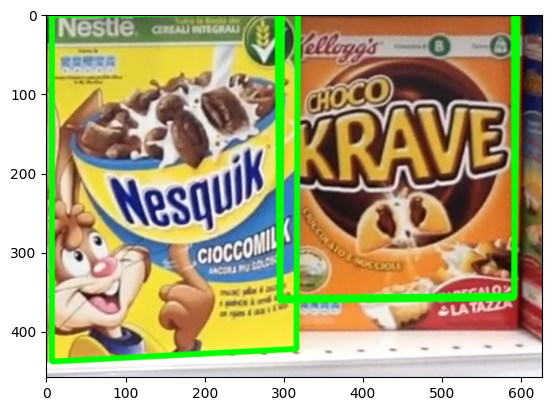

Product 24 found
	Position: ((167, 219))
Product 26 found
	Position: ((538, 218))
Product 25 found
	Position: ((878, 232))


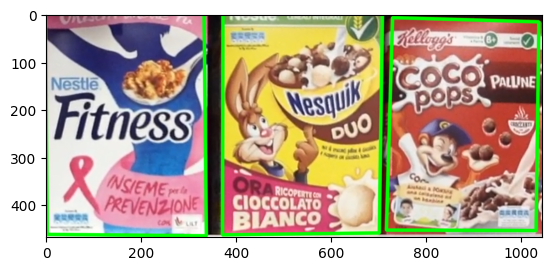

Product 0 found
	Position: ((170, 236))
Product 1 found
	Position: ((817, 194))
Product 11 found
	Position: ((475, 189))


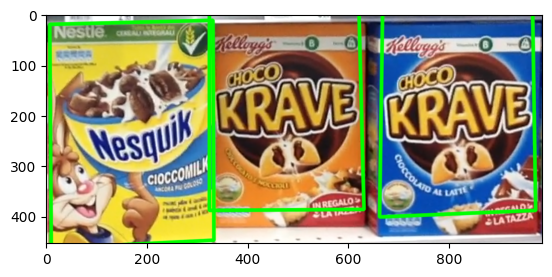

Product 0 found
	Position: ((158, 739))
Product 1 found
	Position: ((464, 687))
Product 11 found
	Position: ((463, 690))
Product 26 found
	Position: ((205, 195))
Product 25 found
	Position: ((554, 208))


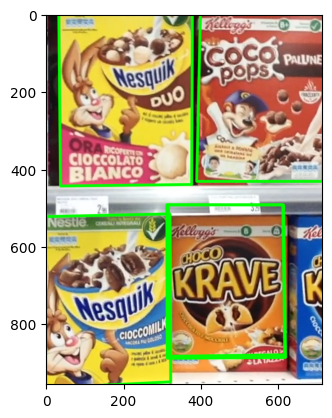

Product 19 found
	Position: ((504, 190))
Product 25 found
	Position: ((160, 227))


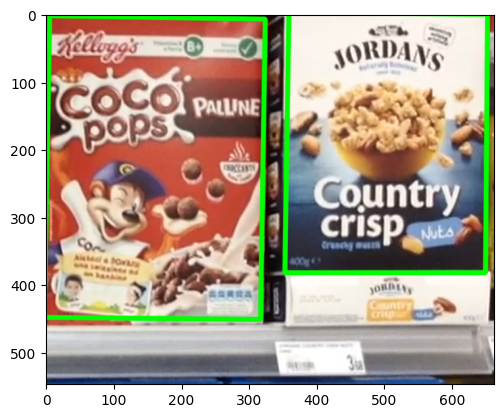

In [40]:
models = ['0', '1', '11', '19', '24', '26', '25']
scenes = ['e1','e2','e3','e4','e5']


for scene in scenes:
    img_scene = cv2.imread(f'scenes/{scene}.png')[:,:,::-1]
    for model in models:
        img_model = cv2.imread(f"models/{model}.jpg")[:,:,::-1]
        img_model = adaptImage(img_model)
        img_scene = object_retrieve(img_query=img_model, product=model, img_train=img_scene, MIN_MATCH_COUNT=130)

    plt.imshow(img_scene)
    plt.show()